# Data preparation

In [25]:
import pandas as pd

In [26]:
data_file = "D:\studia\PRO\inzynierka\dane.data"
train_data = pd.read_csv(data_file, sep='\t', header=0, low_memory=False)
train_data.head()

PhraseId  SentenceId                                             Phrase  \
0         1           1  A series of escapades demonstrating the adage ...   
1         2           1  A series of escapades demonstrating the adage ...   
2         3           1                                           A series   
3         4           1                                                  A   
4         5           1                                             series   

   Sentiment  
0          1  
1          2  
2          2  
3          2  
4          2

In [27]:
test_data_file = "D:\studia\PRO\inzynierka\\test.tsv"
test_data = pd.read_csv(test_data_file, sep='\t', header=0, low_memory=False)
test_data.head()

PhraseId  SentenceId                                             Phrase
0    156061        8545  An intermittently pleasing but mostly routine ...
1    156062        8545  An intermittently pleasing but mostly routine ...
2    156063        8545                                                 An
3    156064        8545  intermittently pleasing but mostly routine effort
4    156065        8545         intermittently pleasing but mostly routine

In [28]:
train_phrases = train_data.iloc[0:, -2]
train_phrases.head()

0    A series of escapades demonstrating the adage ...
1    A series of escapades demonstrating the adage ...
2                                             A series
3                                                    A
4                                               series
Name: Phrase, dtype: object

In [29]:
test_phrases = test_data.iloc[0:, -1]
test_phrases.head()

0    An intermittently pleasing but mostly routine ...
1    An intermittently pleasing but mostly routine ...
2                                                   An
3    intermittently pleasing but mostly routine effort
4           intermittently pleasing but mostly routine
Name: Phrase, dtype: object

In [30]:
train_labels = train_data.iloc[0:, -1]
train_labels.head()

0    1
1    2
2    2
3    2
4    2
Name: Sentiment, dtype: int64

##  Vectorization

### Tokenization

In [31]:
import re

def custom_tokenizer(phrase):
    clean_phrase = phrase.lower()
    clean_phrase = re.sub("[^a-z]", " ", clean_phrase)
    
    for _ in ['not', 'no']:
        pattern = "(^|\s+)" + _ + "\s+"
        clean_phrase = re.sub(pattern, " " + _, clean_phrase)
        
    for _ in ['don t', 'doesn t', 'won t', 'wouldn t', 'haven t', 'hasn t', 'couldn t', 'can t', 'must n']:
        pattern = "(^|\s)+" + _ + "\s+"
        clean_phrase = re.sub(pattern, " not", clean_phrase)
                                   
    clean_phrase = re.sub("(^|\s+)[a-z]\s+", " ", clean_phrase)
    
    for _ in ['the', 'an', 'of', 'with']:
        pattern = "(^|\s+)" + _ + "\s+"
        clean_phrase = re.sub(pattern, " ", clean_phrase)
    
    return clean_phrase.split()

### Term Frequency-Inverse Document Frequency

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, analyzer='word')

In [33]:
len(test_phrases)

66292

In [34]:
train_phrases

0         A series of escapades demonstrating the adage ...
1         A series of escapades demonstrating the adage ...
2                                                  A series
3                                                         A
4                                                    series
                                ...                        
156055                                            Hearst 's
156056                            forced avuncular chortles
156057                                   avuncular chortles
156058                                            avuncular
156059                                             chortles
Name: Phrase, Length: 156060, dtype: object

In [35]:
all_phrases = train_phrases.append(test_phrases, ignore_index=True)
vectorized_all_phrases = tfidf_vectorizer.fit_transform(all_phrases)

In [36]:
train_vectorized_phrases = vectorized_all_phrases[0:156060,:]
test_vectorized_phrases = vectorized_all_phrases[156060:,:]

In [37]:
train_vectorized_phrases

<156060x18043 sparse matrix of type '<class 'numpy.float64'>'
	with 889765 stored elements in Compressed Sparse Row format>

In [38]:
test_vectorized_phrases

<66292x18043 sparse matrix of type '<class 'numpy.float64'>'
	with 352923 stored elements in Compressed Sparse Row format>

# Useful functions

In [39]:
from sklearn import metrics
from seaborn import heatmap
import matplotlib.pyplot as plt


def plot_heatmap(matrix, accuracy, labels, title):
    heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title("Accuracy: {:0.2f}%".format(accuracy * 100))
    plt.suptitle(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    
def plot(predictions, title):
    label_set = set(train_labels)
    matrix = metrics.confusion_matrix(train_labels, predictions, labels=list(label_set))
    accuracy = metrics.accuracy_score(train_labels, predictions)
    plot_heatmap(matrix, accuracy, label_set, title)

# Support Vector Machine

In [40]:
from sklearn.svm import LinearSVC
svc_classifier_tfidf = LinearSVC(max_iter=5000)

In [41]:
svc_classifier_tfidf.fit(train_vectorized_phrases, train_labels)

LinearSVC(max_iter=5000)

In [42]:
predictions_test  = svc_classifier_tfidf.predict(test_vectorized_phrases)

In [43]:
predictions_cross_validation = svc_classifier_tfidf.predict(train_vectorized_phrases)

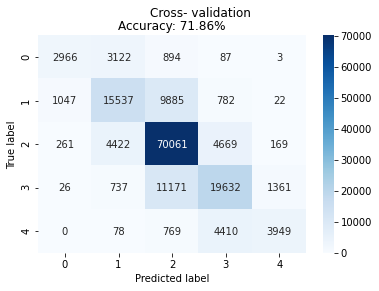

In [44]:
plot(predictions_cross_validation, "Cross- validation")


# Results

In [45]:
test_data['Sentiment'] = predictions_test

In [46]:
test_data

PhraseId  SentenceId  \
0        156061        8545   
1        156062        8545   
2        156063        8545   
3        156064        8545   
4        156065        8545   
...         ...         ...   
66287    222348       11855   
66288    222349       11855   
66289    222350       11855   
66290    222351       11855   
66291    222352       11855   

                                                  Phrase  Sentiment  
0      An intermittently pleasing but mostly routine ...          3  
1      An intermittently pleasing but mostly routine ...          3  
2                                                     An          2  
3      intermittently pleasing but mostly routine effort          3  
4             intermittently pleasing but mostly routine          3  
...                                                  ...        ...  
66287             A long-winded , predictable scenario .          1  
66288               A long-winded , predictable scenario          1  
66289                                    A long-winded ,          1  
66290                                      A long-winded          1  
66291                               predictable scenario          2  

[66292 rows x 4 columns]

In [47]:
test_data[["PhraseId", "Sentiment"]].to_csv("submission.csv", index=False)